### Austun Louw (ASTAUS001)
#### Question 1

In [ ]:
import sys,os
import numpy as np
from matplotlib.pyplot import *
from astropy.io.votable import parse_single_table
from astropy.table import Table,Column
from scipy.interpolate import CubicSpline, PPoly
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

deg2rad = np.pi/180.0 
fieldsolidangle = 1.8   # solid angle of area of source search in square degrees. 
sourcefile = 'sources/sources.txt'
#datadir='pybdsf/'
#os.chdir(datadir)


Standard Deviation: 0.034979355876015146 mJy
Mean: 0.011309899749373435 mJy
Total Flux Density: 90.25300000000001 mJy


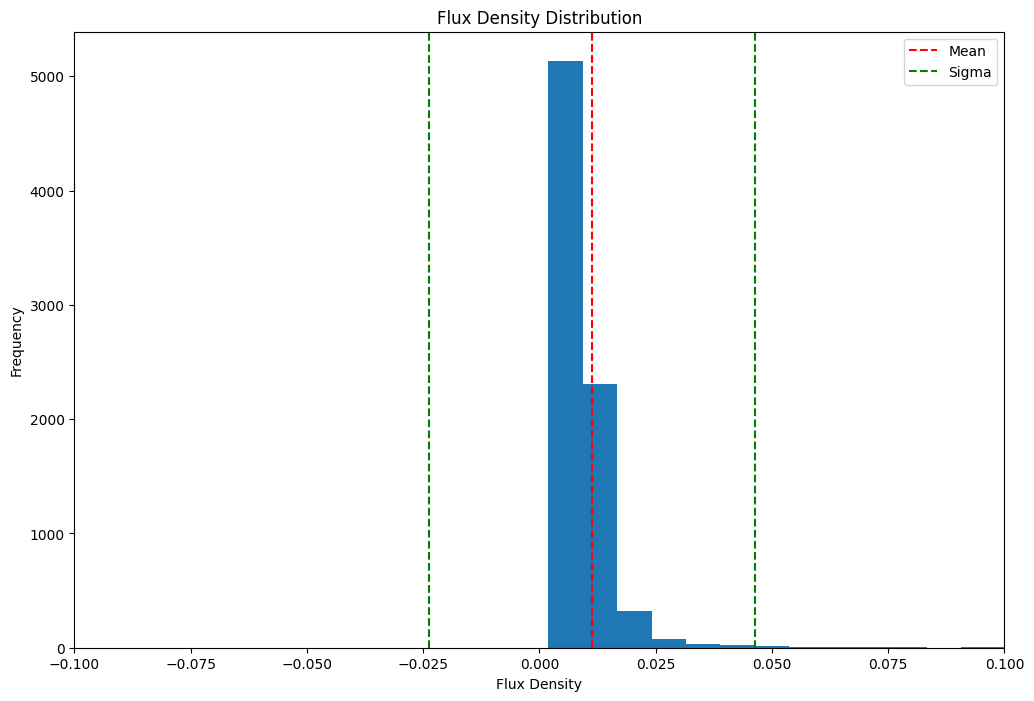

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

xrange = (-0.1,0.1)   # data value range over which to plot distributions


try:
    # Read the data from the text file into a DataFrame
    df = pd.read_csv(sourcefile, sep='\s+')  # Assuming the data is tab-separated

    # Specify the column name you want to analyze
    column_name = 'i_flux'

    # Check if the column exists in the DataFrame
    if column_name in df.columns:
        # Calculate the standard deviation and mean of the specified column
        
        df = df.drop(df.index[0])
        std = (df[column_name].astype(float)).std()
        mean = (df[column_name].astype(float)).mean()

        print("Standard Deviation:", std, 'mJy')
        print("Mean:", mean, 'mJy')
    else:
        print("Column not found in the DataFrame.")
except FileNotFoundError:
    print("File not found. Please provide the correct file path.")
except pd.errors.EmptyDataError:
    print("The file is empty or does not contain any data.")
except Exception as e:
    print("An error occurred:", str(e))

#total integrated flux
total_flux_density = (df['i_flux'].astype(float)).sum()

print("Total Flux Density:", total_flux_density, 'mJy')


flux = df['i_flux'].astype(float)

# Plot the flux density distribution histogram
figure(figsize=(12,8))
plt.hist(flux, bins=200) 
plt.xlabel('Flux Density')
plt.ylabel('Frequency')
plt.title('Flux Density Distribution')
plt.xlim(xrange)
# plt.grid(True)

# Plot mean and sigma lines
plt.axvline(x=mean, color='red', linestyle='--', label='Mean')
plt.axvline(x=mean + std, color='green', linestyle='--', label='Sigma')
plt.axvline(x=mean - std, color='green', linestyle='--')
plt.legend()
savefig('histo.png')
plt.show()


In [ ]:
# df = df.astype(float)
# snrthreshold = 4.0 
# #df = df.drop(df.index[0])
# i = 1
# while i<=len(df):
#         snr = df.dec_err[i]/df.p_err[i]
#         if (snr>snrthreshold):
#             plot(df[i].id,df[i].ra_err,'k.')
#         else:
#             plot(df.id[i],df.ra_err[i],'ro')
# grid(True)
# #savefig(srcdir+'positions.png')
# show()

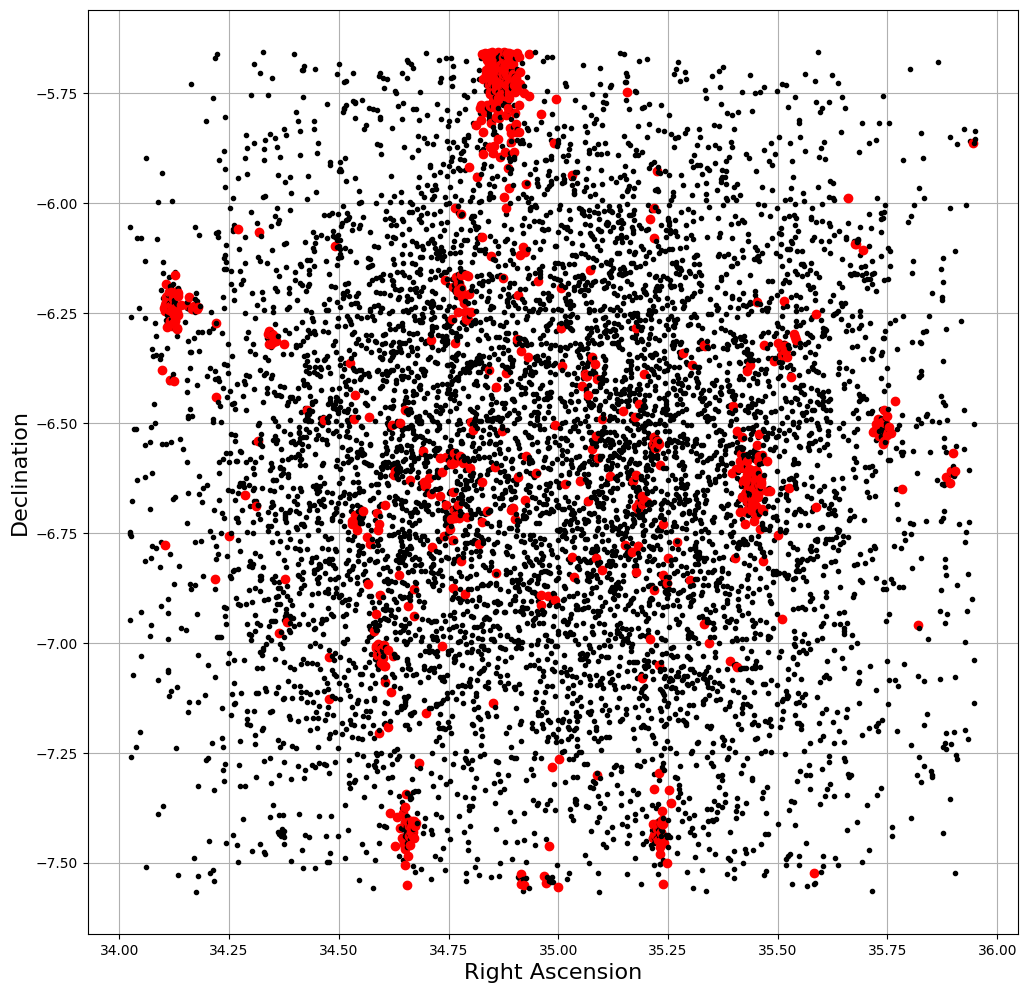

In [ ]:
figure(figsize=(12,12))
xlabel('Right Ascension',fontsize=16)
ylabel('Declination',fontsize=16)
snrthreshold = 4.0                         # S/N threshold for source fit for detection

df = df.astype(float)
#df = df.drop(df.index[0])
i = 1
while i<=len(df):
    snr = df.dec_err[i]/df.p_err[i]
    if (snr>snrthreshold):
        plot(df.id[i],df.ra_err[i],'k.')
    else:
        plot(df.id[i],df.ra_err[i],'ro')
    i+=1
grid(True)
savefig('positions.png')
show()

In [10]:
i_flux = df.dec_err.astype(float)
i_err = df.i_flux.astype(float)
p_flux = df.i_err.astype(float)
p_err = df.p_flux.astype(float)
ratio = i_flux/p_flux
uncertainty = np.sqrt(i_err**2 + p_err**2)
sigma = (i_flux - p_flux) / uncertainty
resolved = sigma > 3
#resolved = df['int_flux'] / df['peak_flux'] > 1.3

point_sources = df[~resolved]
print(point_sources)
med = np.median(point_sources.i_flux.astype(float) / point_sources.p_flux.astype(float) )
print('Median int/flux ratio for unresolved sources in {0:.2f}'.format(med))

           #        id    ra   ra_err   dec  dec_err  i_flux   i_err  p_flux  \
1        1.0  34.02410  0.90 -6.74825  0.99   0.0893  0.0190  0.0605  0.0106   
2        2.0  34.02416  0.86 -6.75284  0.75   0.0849  0.0175  0.0626  0.0106   
3        3.0  34.02501  0.73 -6.94859  0.81   0.0740  0.0148  0.0675  0.0117   
4        4.0  34.02502  0.54 -6.05526  0.56   0.1439  0.0204  0.1054  0.0134   
5        5.0  34.02608  0.94 -6.25840  0.95   0.0931  0.0218  0.0629  0.0118   
...      ...       ...   ...      ...   ...      ...     ...     ...     ...   
7974  7974.0  35.94484  0.51 -5.86226  0.50   0.0821  0.0141  0.1155  0.0180   
7976  7976.0  35.94681  0.52 -7.03964  0.51   0.0760  0.0121  0.0856  0.0125   
7977  7977.0  35.94705  0.31 -5.86433  0.32   0.1453  0.0152  0.1859  0.0178   
7978  7978.0  35.94708  0.65 -6.50255  0.64   0.0803  0.0141  0.0676  0.0106   
7979  7979.0  35.94897  0.65 -5.83578  0.66   0.1652  0.0280  0.1208  0.0178   

       p_err    rms     a  a_err     b 

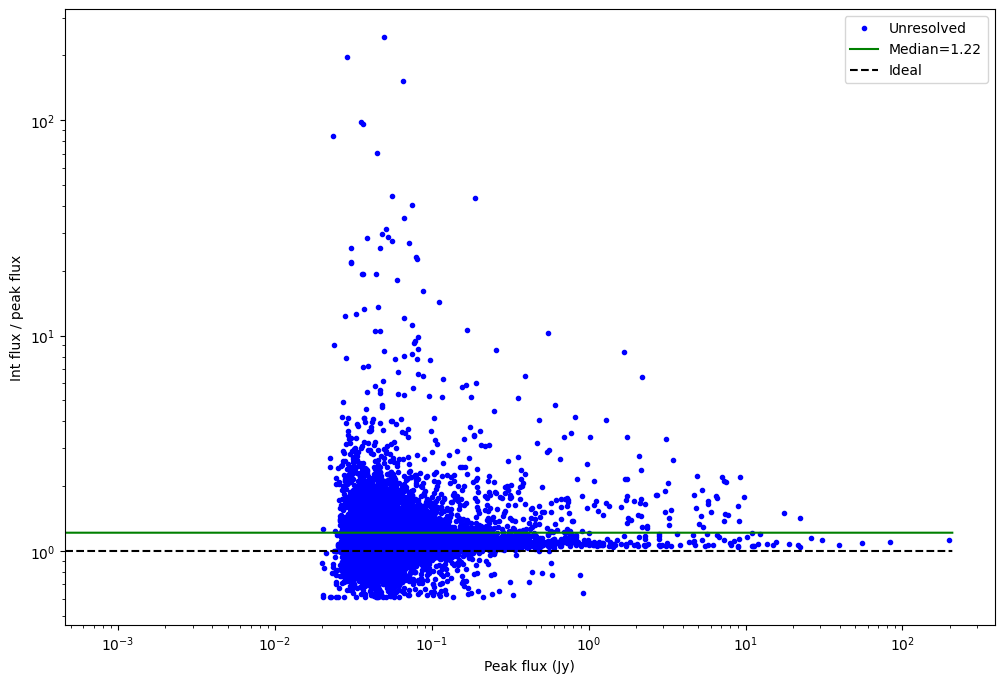

In [12]:
#fig = plt.figure(**figsize)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.plot(p_flux,ratio,'.',c='b',label='Unresolved')
ax.set_xlabel('Peak flux (Jy)')
ax.set_ylabel('Int flux / peak flux')
xlim = plt.gca().get_xlim()
x = np.arange(xlim[0],xlim[1],1e-3)
y = np.ones_like(x)*med
y0 = np.ones_like(x)
ax.plot(x,y,c='g',label='Median={0:.2f}'.format(med))
ax.plot(x,y0,c='black',ls='--',label='Ideal')
ax.loglog()
ax.legend()
fig.savefig('ratio.png')
plt.show()